In [38]:
import nltk
import pandas as pd
import numpy as np
nltk.download('punkt')  # Tokenizer
nltk.download('wordnet')  # WordNet for word relationships
nltk.download('averaged_perceptron_tagger')  # Part-of-speech tagging
nltk.download('omw-1.4')  # Open Multilingual WordNet (if required)

from nrclex import NRCLex
from src.data.beerdata_loader import BeerDataLoader
from pandarallel import pandarallel
from src.data.process_reviews import preprocess_text

import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Qrnqult\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Qrnqult\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Qrnqult\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Qrnqult\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
beer_data_loader = BeerDataLoader(data_dir="../ada-2024-project-data-crusadas/src/data/BeerAdvocate", force_process=False)

reviews_df, ratings_df, beers_df, breweries_df, users_df = beer_data_loader.load_all_data()

Processed file '../ada-2024-project-data-crusadas/src/data/BeerAdvocate\reviews_processed.csv' already exists. Skipping processing.
Processed file '../ada-2024-project-data-crusadas/src/data/BeerAdvocate\ratings_processed.csv' already exists. Skipping processing.


### Emotion Detection using NRCLex ###

NRCLex is a Python library that provides a simple interface for accessing the NRC Emotion Lexicon, which is a list of words and their associations with eight basic emotions (anger, fear, anticipation, trust, surprise, sadness, joy, and disgust) and two sentiments (positive and negative). This lexicon can be used to perform emotion detection on text data.

In this notebook, I am going to use NRCLex to detect emotions in the text reviews for each beer. The detected emotions will be added to the dataset for further analysis.

The next cell is the way to obtain the emotions from the reviews

In [ ]:
# example for one review
review = reviews_df['review'][0]

# Create an instance of NRCLex
text_object = NRCLex(review)
print(text_object.affect_frequencies)

pandarallel.initialize(progress_bar=True)

# takes a while to run
#Now we are going to add a column for each emotion based on NRCLex's affect_frequencies for each review.
reviews_df['emotions_dict'] = reviews_df['text'].fillna('').astype(str).parallel_apply(
    lambda x: NRCLex(preprocess_text(x, noun_adj_only=False)).affect_frequencies
)
# expand the dictionnary into separate columns
affect_df = pd.DataFrame(reviews_df['affect_frequencies'].tolist())

merged_df = pd.concat([reviews_df, affect_df], axis=1)

merged_df = merged_df.drop(columns=['affect_frequencies'])

merged_df = merged_df['anticipation'].fillna(0)

THe previous cell takes a while to run. Here is a way to direclty download the processed reviews, where each reviews is assigned a value for each emotions

In [3]:
emotions_df = pd.read_csv('../ada-2024-project-data-crusadas/src/data/emotions_dict.csv')

In [4]:
import ast
import swifter
emotions_df['emotions_dict'] = emotions_df['emotions_dict'].swifter.apply(ast.literal_eval)
affect_df = pd.DataFrame(emotions_df['emotions_dict'].tolist())
merged_df = pd.concat([reviews_df, affect_df], axis=1)
merged_df['anticipation'] = merged_df['anticipation'].fillna(0)
merged_df = merged_df.drop(columns=['anticip'])

Pandas Apply:   0%|          | 0/2589586 [00:00<?, ?it/s]

Now we assign to each beer its corresponding cluster id

In [7]:
import json
with open('./src/data/partition.json', 'r') as f:
    partition = json.load(f)

In [8]:
# we assign a cluster id to each review and set to -1 if the beer_id is not in the partition
merged_df['cluster_id'] = merged_df['beer_id'].apply(lambda x: partition.get(str(x), -1))

# we remove the reviews that are not in a cluster
merged_df = merged_df[merged_df['cluster_id'] != -1]

The main idea here is to show which emotions give every word. We are now able to show which emotions are present in the reviews containing a given word. But because the beer lexicon is extensive, we show here only the top two words for appearance descriptors and the top two words for appearance descriptor in each cluster. 

In [151]:
data = {
    'Cluster': [0, 1, 2, 3, 4, 5, 6, 7, 8],
    'Description': [
        ['yellow', 'light', 'floral', 'grain'],  # Descriptor for cluster 0
        ['dark', 'brown', 'chocolate', 'vanilla'],  # Descriptor for cluster 1
        ['orange', 'amber', 'citrus', 'pine'],
        ['dark', 'brown', 'chocolate', 'coffee'],
        ['orange', 'white', 'yeast', 'wheat'],
        ['amber', 'brown', 'sweet', 'caramel'],
        ['hazy', 'golden', 'citrus', 'bitter'],
        ['light', 'white', 'tart', 'sour'],
        ['golden', 'white', 'wheat', 'sweet']
    ]
}

# Create the DataFrame
df = pd.DataFrame(data)

In [ ]:
def show_spider_emotions_descriptors(emotion_means, cluster_number):
    # Radar chart setup
    categories = ["joy", "trust", "anticipation", "disgust", "surprise", "anger", "sadness", "fear"]
    num_vars = len(categories)

    # Create angles for radar chart
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Repeat the first angle to close the circle

    # Initialize radar chart
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Plot each cluster
    for i, row in emotion_means.iterrows():
        values = row[categories].values.flatten().tolist()
        values += values[:1]  # Repeat the first value to close the circle
        ax.plot(angles, values, label=row['Descriptor'])
        #ax.fill(angles, values, alpha=0.1)  # Optional: Add transparency to fill

    # Add labels and title
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)
    ax.set_yticks([0.05, 0.10, 0.15])
    ax.set_yticklabels(["0.05", "0.10", "0.15"], color="grey", fontsize=8)
    ax.set_ylim(0, 0.16)
    plt.title(f"Emotions from top words of cluster {cluster_number}", size=16, y=1.1)

    # Add legend with cluster mapping
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1), fontsize=8)
    # Show plot
    plt.tight_layout()
    plt.show()

In [135]:
def create_emotions_dataframe(merged_df, descriptors):
    # Create a list to store emotion results for each descriptor
    results = []
    
    # Iterate over the list of descriptors
    for descriptor in descriptors:
        # Vectorize the descriptor search to find rows that match the descriptor
        vectorized_contains = np.vectorize(lambda x: descriptor.lower() in str(x).lower())
        descriptor_rows = merged_df[vectorized_contains(merged_df['text'])]

        # List of emotions to compute the mean for
        emotions_list = ['fear', 'anger', 'trust', 'surprise', 'positive', 'negative', 'sadness', 'disgust', 'joy', 'anticipation']

        # Compute the mean of emotions for the filtered rows
        emotions_descriptor = descriptor_rows[emotions_list].mean()

        # Append the descriptor and its corresponding emotion means to the results list
        results.append([descriptor] + emotions_descriptor.tolist())

    # Create a DataFrame from the results
    emotions_df = pd.DataFrame(results, columns=['Descriptor'] + emotions_list)
    
    return emotions_df

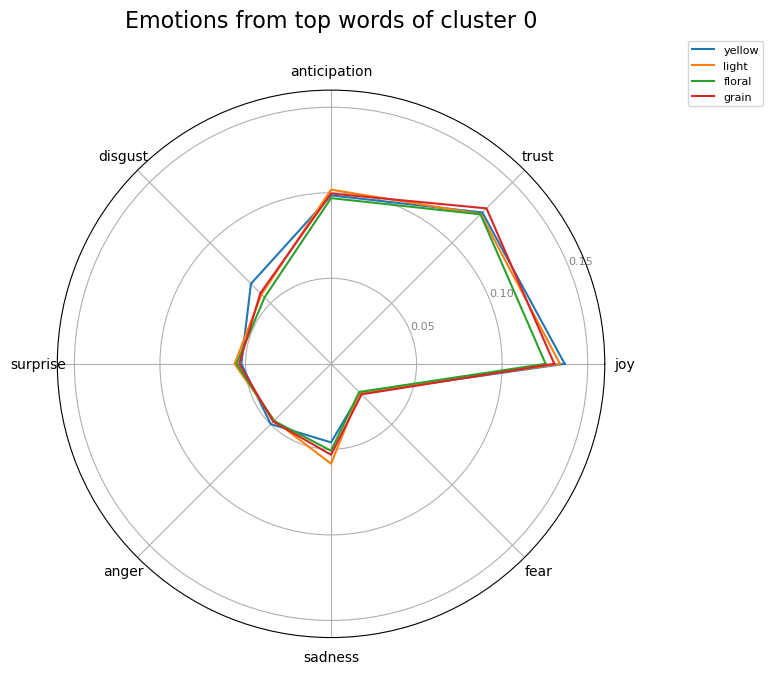

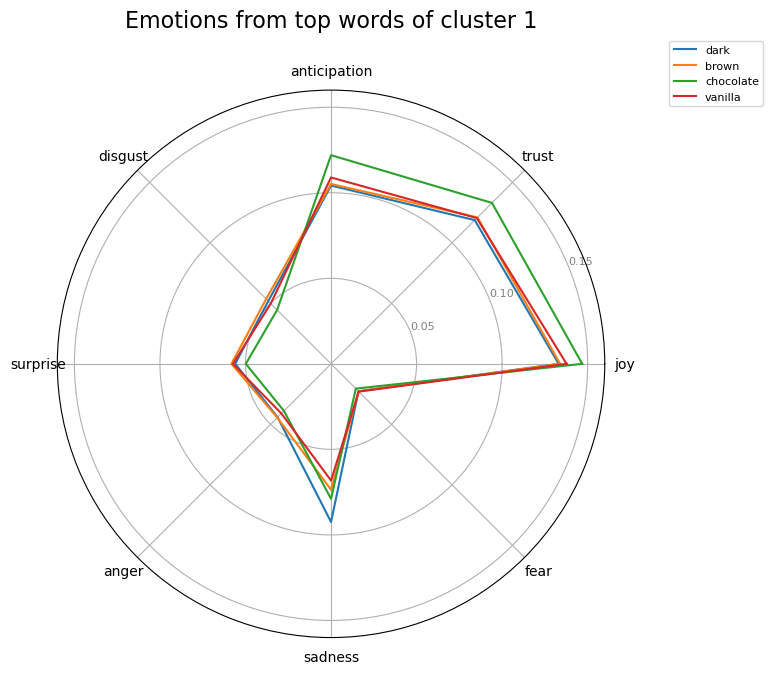

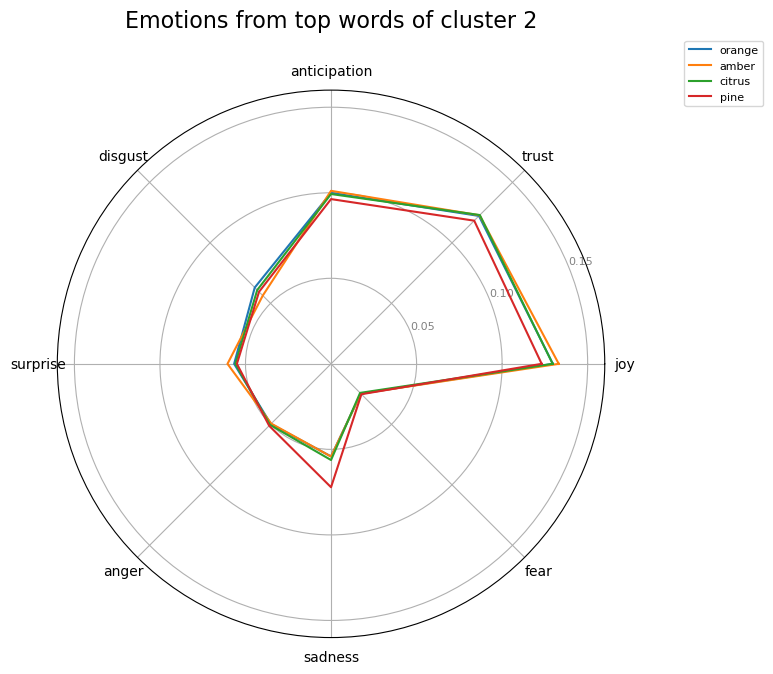

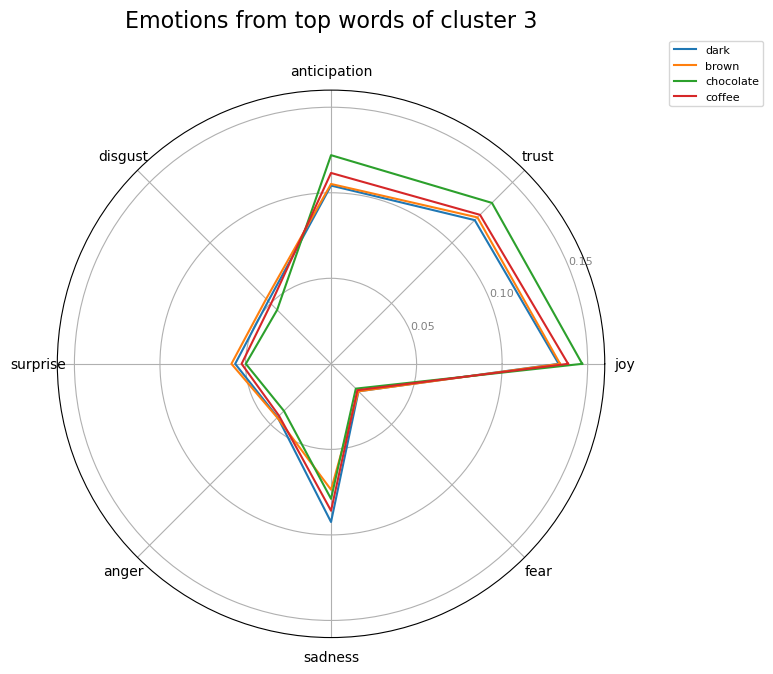

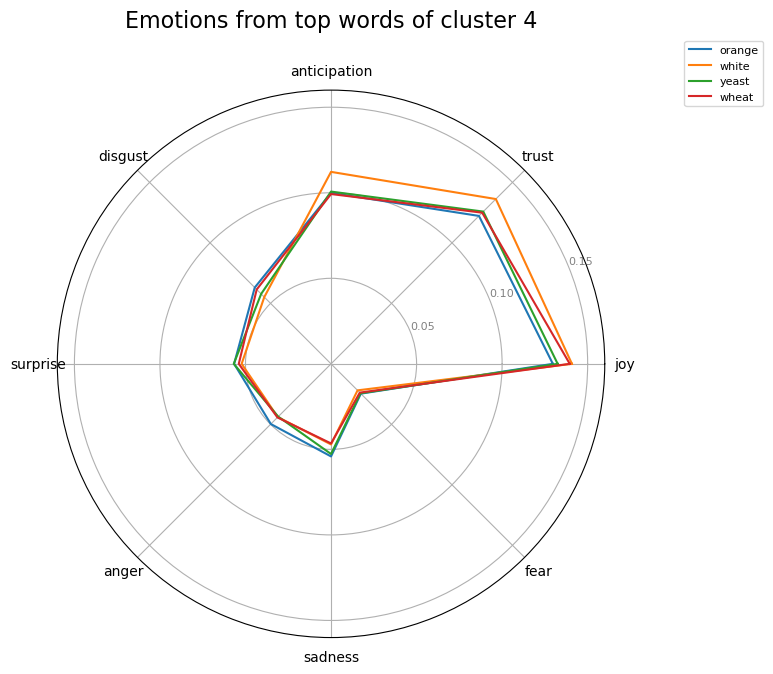

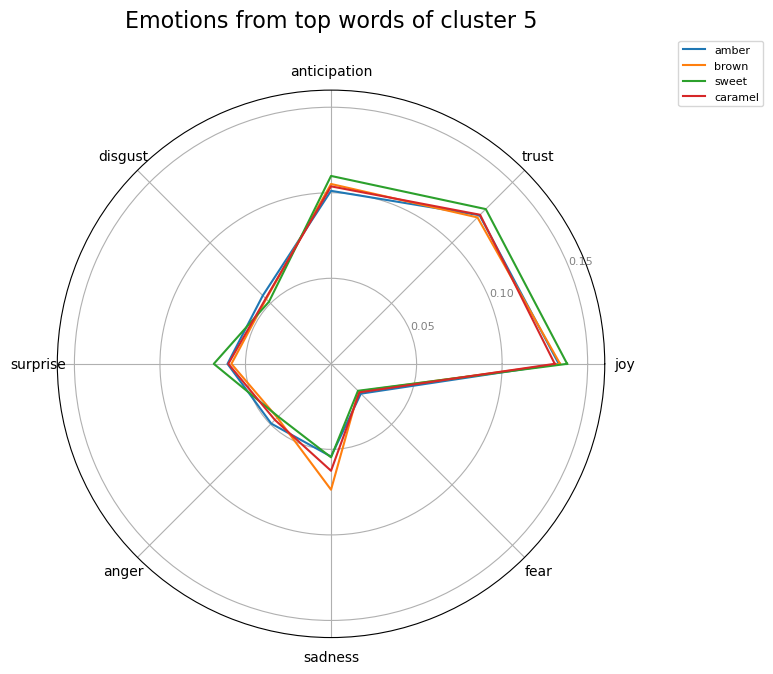

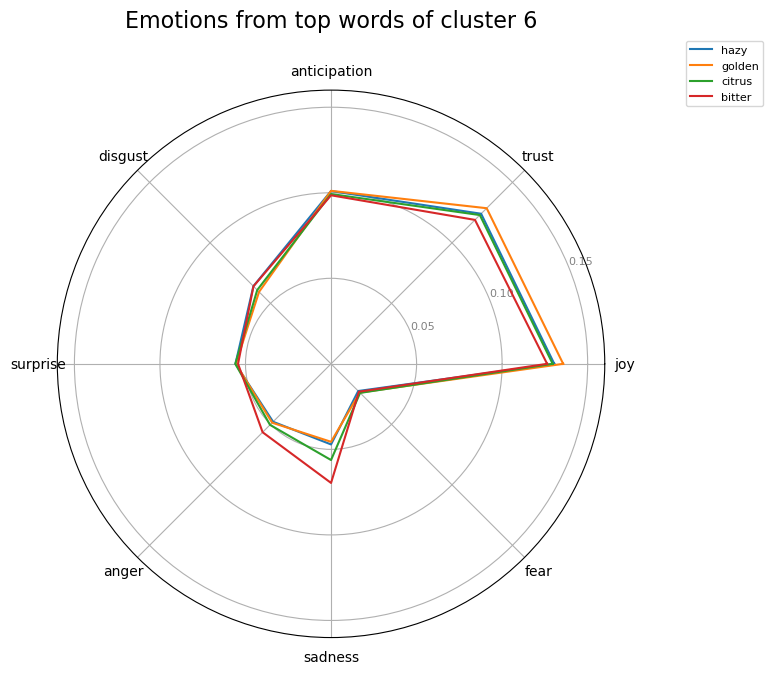

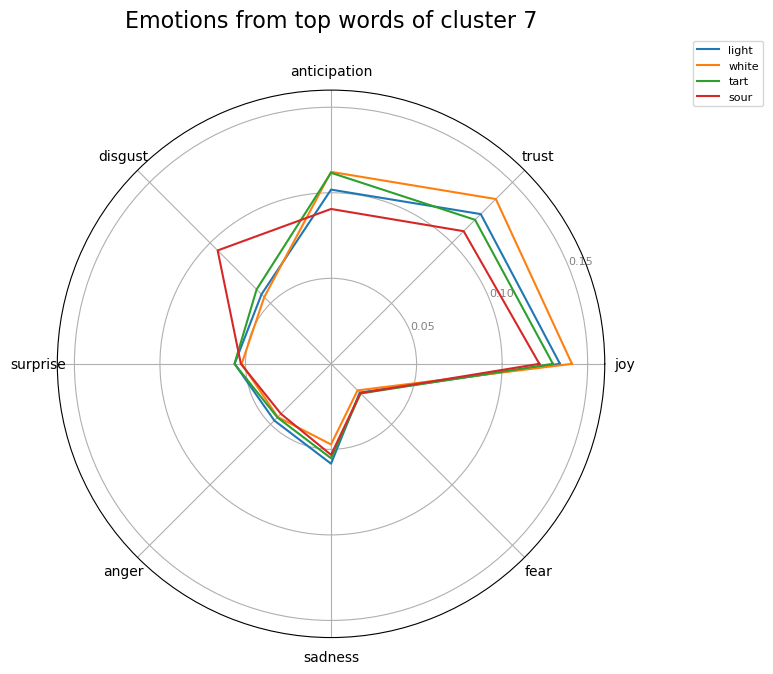

In [140]:
for i in range(0, 8):
    emotion_df = create_emotions_dataframe(merged_df, data['Description'][i])
    show_spider_emotions_descriptors(emotion_df, i)

### Emotion Detection from each cluster ###

We also give the spider map with for each cluster the mean value for each emotion given by the reviews of the given cluster. 

In [144]:
emotions_list = ['fear', 'anger', 'trust', 'surprise', 'positive', 'negative', 'sadness', 'disgust', 'joy', 'anticipation']

# filter the dataframe to include only clusters from 0 to 8 and group by 'cluster_id' and calculate the mean for each emotion column
emotion_means = merged_df[merged_df['cluster_id'].isin(range(9))].groupby('cluster_id')[emotions_list].mean()

for cluster_id in range(9):
    sorted_emotions = emotion_means.loc[cluster_id].sort_values(ascending=False)
    print(f"The biggest emotions that reviewers have felt when drinking beers from cluster {cluster_id} are:")
    print(sorted_emotions)

The biggest emotions that reviewers have felt when drinking beers from cluster 0 are:
positive        0.284291
joy             0.144095
trust           0.128387
negative        0.120505
anticipation    0.095779
disgust         0.056908
surprise        0.052904
anger           0.051128
sadness         0.039402
fear            0.026080
Name: 0, dtype: float64
The biggest emotions that reviewers have felt when drinking beers from cluster 1 are:
positive        0.281501
joy             0.141770
trust           0.117184
negative        0.111989
anticipation    0.107442
sadness         0.066908
surprise        0.057549
disgust         0.048703
anger           0.042414
fear            0.024079
Name: 1, dtype: float64
The biggest emotions that reviewers have felt when drinking beers from cluster 2 are:
positive        0.278521
joy             0.130364
trust           0.119683
negative        0.118318
anticipation    0.097691
disgust         0.060966
surprise        0.057212
sadness         0.0

In [142]:
import pandas as pd

data = {
    "Cluster": [0, 1, 2, 3, 4, 5, 6, 7, 8],
    "joy": [0.144095, 0.141770, 0.130364, 0.138925, 0.139989, 0.138258, 0.136479, 0.126782, 0.138281],
    "trust": [0.128387, 0.117184, 0.119683, 0.122109, 0.125290, 0.120233, 0.118443, 0.110499, 0.117168],
    "anticipation": [0.105092, 0.114276, 0.105503, 0.116016, 0.108394, 0.109524, 0.110560, 0.098722, 0.106653],
    "disgust": [0.056908, 0.048703, 0.060966, 0.049109, 0.059914, 0.053235, 0.057827, 0.087840, 0.049848],
    "surprise": [0.052904, 0.057549, 0.057212, 0.052443, 0.055454, 0.063128, 0.055838, 0.053447, 0.062342],
    "anger": [0.051128, 0.042414, 0.054228, 0.042717, 0.043880, 0.046410, 0.049943, 0.037312, 0.042825],
    "sadness": [0.039402, 0.066908, 0.056598, 0.087347, 0.043324, 0.057374, 0.051726, 0.046968, 0.037076],
    "fear": [0.026080, 0.024079, 0.025984, 0.022098, 0.023745, 0.024236, 0.025626, 0.021904, 0.023023]
}

df = pd.DataFrame(data)
print(df)

   Cluster       joy     trust  anticipation   disgust  surprise     anger  \
0        0  0.144095  0.128387      0.105092  0.056908  0.052904  0.051128   
1        1  0.141770  0.117184      0.114276  0.048703  0.057549  0.042414   
2        2  0.130364  0.119683      0.105503  0.060966  0.057212  0.054228   
3        3  0.138925  0.122109      0.116016  0.049109  0.052443  0.042717   
4        4  0.139989  0.125290      0.108394  0.059914  0.055454  0.043880   
5        5  0.138258  0.120233      0.109524  0.053235  0.063128  0.046410   
6        6  0.136479  0.118443      0.110560  0.057827  0.055838  0.049943   
7        7  0.126782  0.110499      0.098722  0.087840  0.053447  0.037312   
8        8  0.138281  0.117168      0.106653  0.049848  0.062342  0.042825   

    sadness      fear  
0  0.039402  0.026080  
1  0.066908  0.024079  
2  0.056598  0.025984  
3  0.087347  0.022098  
4  0.043324  0.023745  
5  0.057374  0.024236  
6  0.051726  0.025626  
7  0.046968  0.021904  
8  

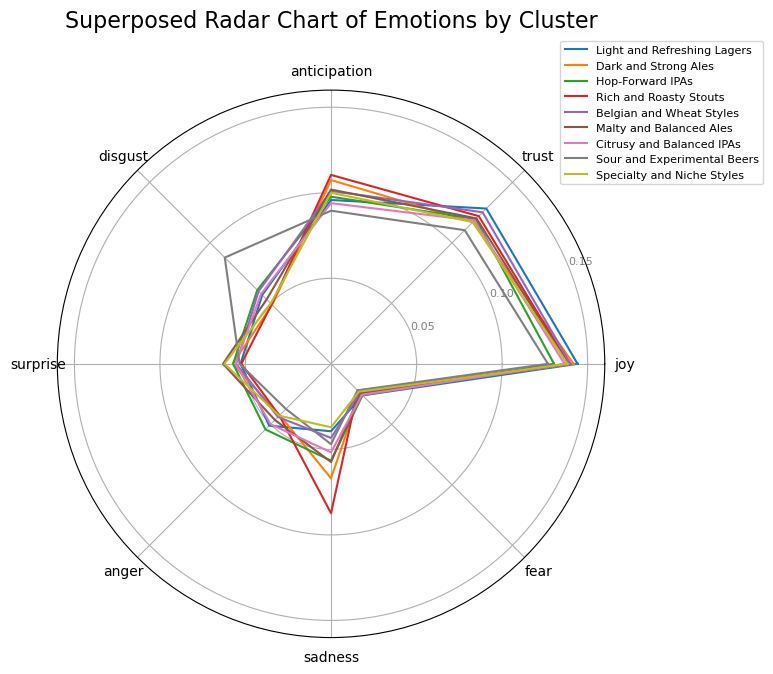

In [147]:
def show_spider_emotions(emotion_means):
    # Cluster mapping
    cluster_mapping = {
        0: 'Light and Refreshing Lagers',
        1: 'Dark and Strong Ales',
        2: 'Hop-Forward IPAs',
        3: 'Rich and Roasty Stouts',
        4: 'Belgian and Wheat Styles',
        5: 'Malty and Balanced Ales',
        6: 'Citrusy and Balanced IPAs',
        7: 'Sour and Experimental Beers',
        8: 'Specialty and Niche Styles'
    }

    # Radar chart setup
    categories = ["joy", "trust", "anticipation", "disgust", "surprise", "anger", "sadness", "fear"]
    num_vars = len(categories)

    # Create angles for radar chart
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Repeat the first angle to close the circle

    # Initialize radar chart
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Plot each cluster
    for i, row in emotion_means.iterrows():
        values = row[categories].values.flatten().tolist()
        values += values[:1]  # Repeat the first value to close the circle
        ax.plot(angles, values, label=cluster_mapping[i])
        #ax.fill(angles, values, alpha=0.1)  # Optional: Add transparency to fill

    # Add labels and title
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)
    ax.set_yticks([0.05, 0.10, 0.15])
    ax.set_yticklabels(["0.05", "0.10", "0.15"], color="grey", fontsize=8)
    ax.set_ylim(0, 0.16)
    plt.title("Superposed Radar Chart of Emotions by Cluster", size=16, y=1.1)

    # Add legend with cluster mapping
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1), fontsize=8)
    # Show plot
    plt.tight_layout()
    plt.show()

show_spider_emotions(emotion_means)


In [149]:
cluster_mapping = {
        0: 'Light and Refreshing Lagers',
        1: 'Dark and Strong Ales',
        2: 'Hop-Forward IPAs',
        3: 'Rich and Roasty Stouts',
        4: 'Belgian and Wheat Styles',
        5: 'Malty and Balanced Ales',
        6: 'Citrusy and Balanced IPAs',
        7: 'Sour and Experimental Beers',
        8: 'Specialty and Niche Styles'
    }

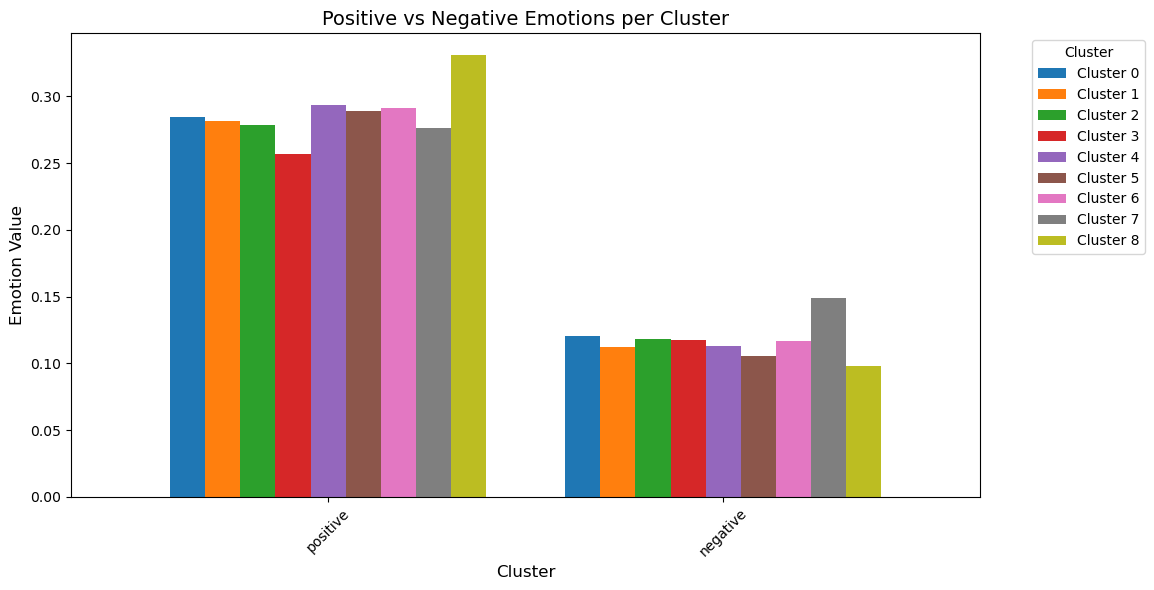

In [150]:
data = {
    'Cluster 0': {'positive': 0.284291, 'negative': 0.120505},
    'Cluster 1': {'positive': 0.281501, 'negative': 0.111989},
    'Cluster 2': {'positive': 0.278521, 'negative': 0.118318},
    'Cluster 3': {'positive': 0.256854, 'negative': 0.117649},
    'Cluster 4': {'positive': 0.293640, 'negative': 0.113278},
    'Cluster 5': {'positive': 0.289090, 'negative': 0.105834},
    'Cluster 6': {'positive': 0.291327, 'negative': 0.116874},
    'Cluster 7': {'positive': 0.276288, 'negative': 0.149061},
    'Cluster 8': {'positive': 0.330756, 'negative': 0.098293}
}

# Convert the dictionary into a DataFrame
df = pd.DataFrame(data)

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Create a grouped bar chart
df.plot(kind='bar', ax=ax, width=0.8)

# Adding title and labels
ax.set_title('Positive vs Negative Emotions per Cluster', fontsize=14)
ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Emotion Value', fontsize=12)

# Show legend and plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.show()